In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
import random
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states_list = [torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions_list = [torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states_list = [torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]            
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states_list, actions_list, rewards, next_states_list, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
REPLAY_BUFFER = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)


In [38]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 250         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 3e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic 
LR_INFERRED_POLICY = 2e-4        # learning rate of the critic 

INFEERED_POLICY_WEIGHT_DECAY = 5e-2        # L2 weight decay
NUM_AGENTS = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
from networkforall import Network
from torch.optim import Adam
import torch
import numpy as np


# add OU noise for exploration
from OUNoise import OUNoise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DDPG_Agent:
    def __init__(self, in_actor, hidden_in_actor, hidden_out_actor, out_actor,
                 in_critic, hidden_in_critic, hidden_out_critic, agent_id,lr_actor=1.0e-4, lr_critic=1.0e-3,
                 competitor_policies = None):
        super(DDPG_Agent, self).__init__()
        
        self.actor_local = Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True).to(device)
        self.critic_local = Network(in_critic, hidden_in_critic, hidden_out_critic, 1).to(device)
        self.actor_target = Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True).to(device)
        self.critic_target = Network(in_critic, hidden_in_critic, hidden_out_critic, 1).to(device)
        self.num_policies_swaps = 0
        if competitor_policies is not None:
            self.competitor_policies = competitor_policies
            self.inferred_competitor_policies = None
        else:
            self.other_agent_ids = list(set([indx for indx in range(NUM_AGENTS)]) - set([agent_id]))
            self.competitor_policies = None
            self.inferred_competitor_policies = [{'inferred_policy':Network(in_actor, hidden_in_actor,
                                                         hidden_out_actor, out_actor,actor=True).to(device),
                                                 'agent_id':agent_id,
                                                  'action_mean': [0.0,0.0],
                                                  'action_std':[0.2,0.2]
                                                 }
                                                for agent_id in self.other_agent_ids]
            for inferred_agent in self.inferred_competitor_policies:
                
                inferred_agent['optimizer'] =  Adam(inferred_agent.get('inferred_policy').parameters(),
                                                    lr=LR_INFERRED_POLICY)

        self.noise = OUNoise(out_actor, scale=1.0 )
        
        #indentification
        self.agent_id = agent_id

        self.actor_optimizer = Adam(self.actor_local.parameters(), lr=lr_actor)
        self.critic_optimizer = Adam(self.critic_local.parameters(), lr=lr_critic) #, weight_decay=1.e-5

    def isNone_or_Empty(self,None_or_List):
        
        return (None_or_List is None) or (len(None_or_List) == 0)
    
    def act(self, obs, noise=0.0):
        # get actions in eval mode and swap back to train mode 
        self.actor_local.eval()
        try:
            obs = torch.from_numpy(obs).float().to(device)
        except TypeError as e:
            obs = obs.float().to(device)
        with torch.no_grad():
            action = self.actor_local(obs) + torch.tensor(noise*self.noise.noise()).to(device)
        self.actor_local.train()
        action = torch.clamp(action, -1, 1,) 
        return action
    
    def act_with_gradients(self, obs, noise=0.05):
        # get actions in eval mode and swap back to train mode 
        try:
            obs = torch.from_numpy(obs).float().to(device)
        except TypeError as e:
            obs = obs.float().to(device)
        action = self.actor_local(obs) + torch.tensor(noise*self.noise.noise()).to(device)
        action = torch.clamp(action, -1, 1,) 
        return action
    
    def act_all_policies_with_grads(self,states_list):
        
        actions_list0 = [None for index in range(NUM_AGENTS)]
        actions_list0[self.agent_id] = self.act_with_gradients(states_list[self.agent_id])
        
        for other_agent in self.competitor_policies:
            other_state = states_list[other_agent.agent_id]
            actions_list0[other_agent.agent_id] = other_agent.act_with_gradients(states_list[other_agent.agent_id])
        return actions_list0
    
    def act_all_policies(self,states_list):
        
        actions_list0 = [None for index in range(NUM_AGENTS)]
        actions_list0[self.agent_id] = self.act(states_list[self.agent_id])
        
        for other_agent in self.competitor_policies:
            other_state = states_list[other_agent.agent_id]
            actions_list0[other_agent.agent_id] = other_agent.act(states_list[other_agent.agent_id])
        
        return actions_list0

    def target_act_all_policies(self,states_list):
        
        actions_list0 = [None for index in range(NUM_AGENTS)]
        actions_list0[self.agent_id] = self.target_act(states_list[self.agent_id])
        
        for other_agent in self.competitor_policies:
            other_state = states_list[other_agent.agent_id]
            #make sure to detach other agents actions from comp graph
            actions_list0[other_agent.agent_id] = other_agent.target_act(states_list[other_agent.agent_id])

        return actions_list0
    
    def target_act_with_inferred_policies(self,states_list):
        actions_list0 = [None for index in range(NUM_AGENTS)]
        actions_list0[self.agent_id] = self.target_act(states_list[self.agent_id])
        
        for inferred_agent in self.inferred_competitor_policies:
            
            other_state = states_list[inferred_agent.get('agent_id')]
            next_actions1 = inferred_agent.get('inferred_policy')(other_state)
            actions_list0[inferred_agent.get('agent_id')] = next_actions1

        return actions_list0
    
    
    def gaussain_log(self, x,mean,std):
        mean = torch.tensor(mean)
        std = torch.tensor(std)
        N = x.shape[0]

        term_1 = torch.tensor(-0.5).to(device) * torch.sum(((x - mean.to(device))/std.to(device)).pow(2),dim = 0)
        term_1 = torch.sum(term_1)
       
        term_2 = torch.tensor(-0.5).to(device) * N * torch.log(torch.tensor(2.0 * np.pi)).to(device)
        
        term_3 = - N * torch.log(std).to(device)
        term_3 = torch.sum(term_3)

        
        return term_1 + term_2 + term_3
    
    def gaussian_entropy(self,std):
        #https://sgfin.github.io/2017/03/11/Deriving-the-information-entropy-of-the-multivariate-gaussian/
        std = torch.tensor(std).to(device)
        N = torch.tensor(NUM_AGENTS).to(device)
        # assuming all the co-variances are zero
        # Determinant of a diagonal matrix is the product of the diagonal https://proofwiki.org/wiki/Determinant_of_Diagonal_Matrix
        det_sigma = torch.prod(std).to(device)

        
        return (torch.tensor(0.5).to(device) * (torch.log(det_sigma) + N.float() * torch.log(torch.tensor(np.e * np.pi * 2.0).to(device))))

            
        

    def target_act(self, obs, noise=0.0):
        
        #self.actor_target.eval()
        try:
            obs = torch.from_numpy(obs).float().to(device)
        except TypeError as e:
            obs = obs.float().to(device)
        #with torch.no_grad():
        action = self.actor_target(obs) #+ torch.tensor(noise*self.noise.noise()).to(device)
        #self.actor_target.train()
        action = torch.clamp(action, -1, 1,)
        return action

    def step(self,**kwargs):
        #check if we have not set any other agents.
        if (not self.isNone_or_Empty(kwargs.get('competitor_policies'))):
            self.competitor_policies = kwargs.get('competitor_policies')
        if len(REPLAY_BUFFER) > BATCH_SIZE:
            
            experiences = REPLAY_BUFFER.sample()
            self.learn(experiences, GAMMA,kwargs.get('competitor_policies'))   
            
    def reset(self):
        self.noise.reset()
            
    def learn(self, experiences, gamma,competitor_policies = None):
        
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        #get other policies used for decentralized Q functions
        
        if (not self.isNone_or_Empty(self.competitor_policies)) and (not self.isNone_or_Empty(competitor_policies)):
            
            # initialize targets same as original networks
            self.competitor_policies = competitor_policies

                            
        states_list, actions_list, rewards, next_states_list, dones = experiences
                    
        next_states_tensor = torch.cat(next_states_list, dim=1).to(device)
        states_tensor = torch.cat(states_list, dim=1).to(device)
        actions_tensor = torch.cat(actions_list, dim=1).to(device)

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
                
        if not self.isNone_or_Empty(self.competitor_policies):
            next_actions0 = self.target_act_all_policies(states_list)
        
        elif not self.isNone_or_Empty(self.inferred_competitor_policies):
            next_actions0 = self.target_act_with_inferred_policies(states_list)

        self.critic_optimizer.zero_grad()
        
        # Only train 95% the time
        if (not self.isNone_or_Empty(self.inferred_competitor_policies)) and (np.random.rand() < 0.95):
            for inferred_agent in self.inferred_competitor_policies:
                
                inferred_agent.get('optimizer').zero_grad()
                
                other_state = states_list[inferred_agent.get('agent_id')]
                inferred_actions = inferred_agent.get('inferred_policy')(other_state)

                
                
                #approximate policy loss as per section 4.2 of paper
                log_loss = self.gaussain_log(x = inferred_actions,
                                             mean = inferred_agent.get('action_mean') ,
                                             std = inferred_agent.get('action_std'))
                                
                entropy_regulariztion = self.gaussian_entropy(std = inferred_agent.get('action_std'))

                
                #calculate loss and backprop 
                inferred_policy_loss = log_loss.to(device) + torch.tensor(1e-2).to(device) * entropy_regulariztion.to(device)
                inferred_policy_loss.backward(retain_graph=True)
                inferred_agent.get('optimizer').step()
                
                # update agent mean and std after learning pass
                inferred_agent['action_mean'] = torch.mean(inferred_actions, dim =0 )
                inferred_agent['action_std'] = torch.std(inferred_actions, dim =0 )
        
        next_actions_tensor = torch.cat(next_actions0, dim=1).to(device) 
        
        
        Q_target_input = torch.cat((next_states_tensor,next_actions_tensor), dim=1).to(device)
        with torch.no_grad():
            Q_targets_next = self.critic_target(Q_target_input) 
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards[:,self.agent_id].view(-1,1) + (gamma * Q_targets_next * (1 - dones[:,self.agent_id].view(-1,1)))        
        # Compute critic loss
        Q_expected_input = torch.cat((states_tensor,actions_tensor), dim=1).to(device) 
        Q_expected = self.critic_local(Q_expected_input)
        huber_loss = torch.nn.SmoothL1Loss()
        critic_loss = huber_loss(Q_expected, Q_targets.detach()) 
        # Minimize the loss
        
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        self.actor_optimizer.zero_grad()

        
        # Compute actor loss
        # take the current states and predict actions
        actions_pred = [self.actor_local(states) for states in states_list]
        
        if not self.isNone_or_Empty(self.competitor_policies):
            actions_pred0 = self.act_all_policies_with_grads(states_list)
            
        elif not self.isNone_or_Empty(self.inferred_competitor_policies):
            #cheating. Should use sampled actions but havent tooled buffer to save actions with grads
            actions_pred0 = [self.actor_local(states) for states in states_list]
            
        
        predicted_actions_tensor = torch.cat(actions_pred0, dim=1).to(device)
               
        Loss_input = torch.cat((states_tensor,predicted_actions_tensor), dim=1).to(device) 
        
        actor_loss = -self.critic_local(Loss_input).mean() 
        # Minimize the loss
        actor_loss.backward()        
        #torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [41]:
class MADDPG:

    def __init__(self, random_seed,use_inferred_policies = False,competitor_policies = None):
        self.agents = [DDPG_Agent(in_actor = 24, # input dimension
                         hidden_in_actor = 512,  # 32
                         hidden_out_actor = 256, #16
                         out_actor = 2, # policy action dimension 
                         in_critic = 24 *2 + 2*2,      # critic input = size(obs_full) * 2 [24 * 2] + size(actions) * 2 [2*2] = 52 
                         hidden_in_critic = 512, #32
                         hidden_out_critic = 256,
                         agent_id = x,
                         competitor_policies = competitor_policies) #16
                      for x in range(NUM_AGENTS)]
        self.time_step = 0
        self.use_inferred_policies = use_inferred_policies
    def step(self, states, actions, rewards, next_states, dones):
        
        self.time_step += 1
        REPLAY_BUFFER.add(states, actions, rewards, next_states, dones)

        for agent in self.agents:
            
            if self.use_inferred_policies:
                agent.step(competitor_policies = None)
            else:
                other_policies = [other_agent for other_agent in self.agents if other_agent.agent_id != agent.agent_id]
                agent.step(competitor_policies = other_policies)
            

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def save_weights(self):
        for index, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))
    
    def reset(self):        
        for agent in self.agents:
            agent.reset()

In [25]:
maddpgagent = MADDPG(0,use_inferred_policies = True)


In [35]:
def TRAIN_MADDPG(maddpgagent,n_episodes=7000):#7000
    scores_deque = deque(maxlen=100)
    scores = []
    average_scores_list = []

    for i_episode in range(1, n_episodes+1):                                    
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations               
        score = np.zeros(num_agents)
        episode_timestep = 0

        maddpgagent.reset()

        while True:
            actions = maddpgagent.act(states)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations
            rewards = env_info.rewards         
            dones = env_info.local_done                         
            maddpgagent.step(states, actions, rewards, next_states, dones)   
            states = next_states
            score += rewards  
            episode_timestep += 1

            if any(dones):                                 
                break
        print('epsiode {} is complete after {} time steps '.format(i_episode,episode_timestep))
        score_max = np.max(score)
        scores.append(score_max)
        scores_deque.append(score_max)
        average_score = np.mean(scores_deque)
        average_scores_list.append(average_score)

        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")  

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage score: {:.3f}'.format(i_episode , average_score))

        if average_score >= 0.5:
            maddpgagent.save_weights()
            print("\rSolved in episode: {} \tAverage score: {:.3f}".format(i_episode , average_score))
            break
    return scores , average_scores_list

In [28]:
scores , average_scores_list = TRAIN_MADDPG(maddpgagent,n_episodes=7000)


epsiode 1 is complete after 20 time steps 
Episode 1	Average Score: 0.000epsiode 2 is complete after 14 time steps 
Episode 2	Average Score: 0.000epsiode 3 is complete after 14 time steps 
Episode 3	Average Score: 0.000epsiode 4 is complete after 15 time steps 
Episode 4	Average Score: 0.000epsiode 5 is complete after 14 time steps 
Episode 5	Average Score: 0.000epsiode 6 is complete after 14 time steps 
Episode 6	Average Score: 0.000epsiode 7 is complete after 14 time steps 
Episode 7	Average Score: 0.000epsiode 8 is complete after 14 time steps 
Episode 8	Average Score: 0.000epsiode 9 is complete after 15 time steps 
Episode 9	Average Score: 0.000epsiode 10 is complete after 14 time steps 
Episode 10	Average Score: 0.000epsiode 11 is complete after 14 time steps 
Episode 11	Average Score: 0.000epsiode 12 is complete after 15 time steps 
Episode 12	Average Score: 0.000epsiode 13 is complete after 15 time steps 
Episode 13	Average Score: 0.000epsiode 14 is complete after 14 time steps 

In [31]:
import matplotlib.pyplot as plt

def plot_scores(score_list, running_average_score):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(1, len(score_list) + 1), score_list, label="Episodic score")
    plt.plot(np.arange(1, len(running_average_score) + 1), running_average_score, label="Running average")
    plt.axhline(y=0.5, color="r", linestyle="-", label="Minimum score for solving Env")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.show()

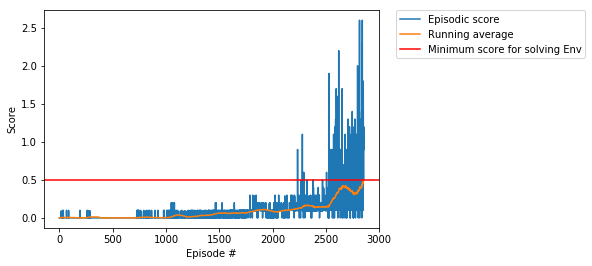

In [32]:
plot_scores(scores , average_scores_list)


In [42]:
maddpgagent_competitors = MADDPG(0,use_inferred_policies = False,competitor_policies = [])


In [43]:
scores_competitors , average_scores_list_competitors = TRAIN_MADDPG(maddpgagent_competitors,n_episodes=7000)

epsiode 1 is complete after 21 time steps 
Episode 1	Average Score: 0.100epsiode 2 is complete after 14 time steps 
Episode 2	Average Score: 0.050epsiode 3 is complete after 14 time steps 
Episode 3	Average Score: 0.033epsiode 4 is complete after 14 time steps 
Episode 4	Average Score: 0.025epsiode 5 is complete after 15 time steps 
Episode 5	Average Score: 0.020epsiode 6 is complete after 14 time steps 
Episode 6	Average Score: 0.017epsiode 7 is complete after 14 time steps 
Episode 7	Average Score: 0.014epsiode 8 is complete after 14 time steps 
Episode 8	Average Score: 0.013epsiode 9 is complete after 14 time steps 
Episode 9	Average Score: 0.011epsiode 10 is complete after 15 time steps 
Episode 10	Average Score: 0.010epsiode 11 is complete after 14 time steps 
Episode 11	Average Score: 0.009epsiode 12 is complete after 14 time steps 
Episode 12	Average Score: 0.008epsiode 13 is complete after 14 time steps 
Episode 13	Average Score: 0.008epsiode 14 is complete after 14 time steps 

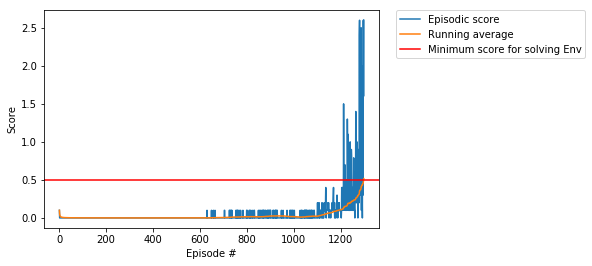

In [44]:
plot_scores(scores_competitors , average_scores_list_competitors)
